In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import time
import re
from concurrent.futures import ThreadPoolExecutor, as_completed 

BASE_URL = "https://archiveofourown.org"
FANDOM_URL = f"{BASE_URL}/fandoms/Chinese%20History%20RPF"
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

MAX_WORKERS = 10 


DELAY_PER_REQUEST = 1.0 




def fetch_page(url, delay=DELAY_PER_REQUEST):
    """
    获取指定 URL 的内容，并进行延时，模拟人类行为。
    """
    try:
        time.sleep(delay) 
        response = requests.get(url, headers=HEADERS, timeout=15)
        response.raise_for_status() 
        return response.text
    except requests.exceptions.RequestException as e:

        print(f"Error fetching {url}: {e}")
        return None


def get_character_data(html_content):
    """
    从 Fandom 页面 HTML 中提取 Canonical Characters 和其 Relationship Tags。
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    character_data = []


    character_lists = soup.find('ul', class_='characters relationships index group')

    if not character_lists:
        print("Could not find the characters list.")
        return []


    for li in character_lists.find_all('li', class_='listbox group'):
        data = {
            'character_name': '',
            'works_url': '',
            'work_number': 0, 
            'relationships': []
        }


        heading = li.find('h4', class_='heading')
        if heading and heading.find('a'):
            char_tag = heading.find('a')
            data['character_name'] = char_tag.text.strip().split('(')[0].strip()
            data['works_url'] = f"{BASE_URL}{char_tag['href']}"


            rel_ul = li.find('ul', class_='tags commas index group')
            if rel_ul:
                for rel_li in rel_ul.find_all('li'):
                    rel_tag = rel_li.find('a')
                    if rel_tag:
                        data['relationships'].append({
                            'relationship_name': rel_tag.text.strip(),
                            'relationship_url': f"{BASE_URL}{rel_tag['href']}"
                        })

            character_data.append(data)

    return character_data


def get_work_count_from_works_page(char_data):
    """
    爬取 Works 页面，提取作品数量。
    """
    works_url = char_data['works_url']
    html_content = fetch_page(works_url, delay=DELAY_PER_REQUEST) 
    
    if not html_content:
        return char_data 

    works_soup = BeautifulSoup(html_content, 'html.parser')

    heading_tag = works_soup.find('h2', class_='heading')

    if heading_tag:
        heading_text = heading_tag.text.strip()
        
        match_simple = re.search(r'^(\d+)\s+Works\s+in', heading_text)
        if match_simple:
            char_data['work_number'] = int(match_simple.group(1))
            return char_data

        match_total = re.search(r'of\s+(\d+)\s+Works\s+in', heading_text)
        if match_total:
            char_data['work_number'] = int(match_total.group(1))
            return char_data

        if re.search(r'^1\s+Work\s+in', heading_text):
            char_data['work_number'] = 1
            return char_data
            
    return char_data


def main_scraper():
    """
    主爬虫函数，使用多线程进行 Works Count 提取。
    """
    print(f"Starting to scrape Fandom: {FANDOM_URL}...")
    
    fandom_html = fetch_page(FANDOM_URL, delay=3) 
    if not fandom_html:
        return

    characters = get_character_data(fandom_html)
    print(f"Found {len(characters)} canonical characters. Starting concurrent works count fetching...")
    

    final_characters = []
    
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        future_to_char = {
            executor.submit(get_work_count_from_works_page, char): char 
            for char in characters
        }

        for i, future in enumerate(as_completed(future_to_char)):
            result_char = future.result()
            final_characters.append(result_char)

            print(f"  [{i+1}/{len(characters)}] Processed: {result_char['character_name']}, Works: {result_char['work_number']}, Relationships: {len(result_char['relationships'])}")
            
                
    output_filename = "ao3_chinese_history_rpf_characters_fixed.json"
    
    if len(final_characters) < len(characters):
        processed_data = final_characters
    else:
        processed_data = final_characters

    with open(output_filename, 'w', encoding='utf-8') as f:
        json.dump(processed_data, f, ensure_ascii=False, indent=4) 

    print(f"\n✅ Scraper finished. Data for {len(processed_data)} characters saved to {output_filename}")


if __name__ == "__main__":
    main_scraper()

Starting to scrape Fandom: https://archiveofourown.org/fandoms/Chinese%20History%20RPF...
Found 2878 canonical characters. Starting concurrent works count fetching...
  [1/2878] Processed: Abe no Nakamaro | Chao Heng, Works: 0, Relationships: 0
  [2/2878] Processed: Antong, Works: 0, Relationships: 0
  [3/2878] Processed: Alingga, Works: 0, Relationships: 1
  [4/2878] Processed: Anqi Sheng, Works: 1, Relationships: 0
  [5/2878] Processed: Ai Nengqi, Works: 2, Relationships: 1
  [6/2878] Processed: Arsungga, Works: 0, Relationships: 0
  [7/2878] Processed: An Qingxu, Works: 5, Relationships: 1
  [8/2878] Processed: Bai Chongxi, Works: 28, Relationships: 7
  [9/2878] Processed: Ahmad Fanakati, Works: 16, Relationships: 7
  [10/2878] Processed: Bai Juyi, Works: 112, Relationships: 9
  [11/2878] Processed: Bai Pu | Bai Renfu, Works: 1, Relationships: 1
  [12/2878] Processed: Ban Chao | Ban Zhongsheng, Works: 0, Relationships: 0
  [13/2878] Processed: Bak Bulhwa, Works: 1, Relationships: 0


In [2]:
import pandas as pd
import json
import re

FILE_PATH = r"\ao3_chinese_history_rpf_characters_safe_concurrent.json"


def load_and_prepare_data(file_path):
    """加载 JSON 文件，并展平数据结构。"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"错误：文件未找到，请检查路径：{file_path}")
        return None
    except json.JSONDecodeError:
        print("错误：JSON 文件格式不正确。")
        return None
        
    df = pd.DataFrame(data)
    
    df['relationship_count'] = df['relationships'].apply(len)
    
    df_main = df.drop(columns=['relationships', 'works_url'])
    
    return df_main, df


def perform_descriptive_stats(df):
    """计算作品数和关系数的描述性统计。"""
    print("## 作品数量 (Works Count) 描述性统计：")
    print(df['work_number'].describe())
    print("\n" + "="*50)
    
    print("## 关系数量 (Relationship Count) 描述性统计：")
    print(df['relationship_count'].describe())
    print("\n" + "="*50)



def extract_time_info(df_full):
    """从角色名和关系名中提取时间信息，并返回新的 DataFrame。"""

    TIME_PATTERN = r'\((.*?)\)'
    
    time_data = []

    for index, row in df_full.iterrows():
        character_name = row['character_name']
        
        matches = re.findall(TIME_PATTERN, character_name)
        
        for match in matches:
            if re.search(r'[\d\?]|CE|BCE|Dynasty|Age|Era|Reign', match, re.IGNORECASE):
                time_data.append({
                    'name': character_name.split('(')[0].strip(), 
                    'source_type': 'Character Name',
                    'time_info': match.strip()
                })

    relationships_flat = []
    for index, row in df_full.iterrows():
        if isinstance(row['relationships'], list):
            for rel in row['relationships']:
                relationships_flat.append(rel['relationship_name'])

    for relationship_name in relationships_flat:
        matches = re.findall(TIME_PATTERN, relationship_name)
        
        for match in matches:
            if re.search(r'[\d\?]|CE|BCE|Dynasty|Age|Era|Reign', match, re.IGNORECASE):
                name_without_time = re.sub(TIME_PATTERN, '', relationship_name).strip()
                name_without_time = name_without_time.strip(' *') 
                
                time_data.append({
                    'name': name_without_time, 
                    'source_type': 'Relationship Name',
                    'time_info': match.strip()
                })

    df_time = pd.DataFrame(time_data)
    

    df_time.drop_duplicates(inplace=True) 
    
    df_time_final = df_time[['name', 'time_info']].rename(columns={
        'name': 'Character/Relationship Name',
        'time_info': 'Time Information Extracted'
    })
    
    return df_time_final


if __name__ == "__main__":
    

    df_stats, df_full = load_and_prepare_data(FILE_PATH)

    if df_stats is not None:
        perform_descriptive_stats(df_stats)
        
        df_time_info = extract_time_info(df_full)
        
        print("## 提取的时间信息 (Time Information Extracted DataFrame)：")
        print(df_time_info.head(20))
        print(f"\n成功提取到 {len(df_time_info)} 条独特的时间信息记录。")
        
        output_csv_path = "extracted_time_info.csv"
        df_time_info.to_csv(output_csv_path, index=False, encoding='utf-8')
        print(f"时间信息已保存到：{output_csv_path}")

## 作品数量 (Works Count) 描述性统计：
count    2878.000000
mean       13.511119
std        57.840645
min         0.000000
25%         1.000000
50%         1.000000
75%         4.000000
max       959.000000
Name: work_number, dtype: float64

## 关系数量 (Relationship Count) 描述性统计：
count    2878.000000
mean        2.337387
std         6.290483
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max       124.000000
Name: relationship_count, dtype: float64

## 提取的时间信息 (Time Information Extracted DataFrame)：
   Character/Relationship Name Time Information Extracted
0                      Alingga                     ?-1716
1                    An Lushan                 703-757 CE
2                       Antong               1248-1293 CE
3                     Arsungga                  ?-1726 CE
4                      Bao Xin                 152-192 CE
5          Bayan of the Merkid                  ?-1340 CE
6                    Bayunying                  1899-1966
7      

发现原始数据中存在 'Dynasty English' 列，正在删除以避免合并冲突。
## 朝代统计结果 (包含作品总数、人物数量和人均作品数):
| Dynasty English                             |   Character Count |   Total Works Count |   Avg Works Per Character |
|:--------------------------------------------|------------------:|--------------------:|--------------------------:|
| Shang                                       |                 3 |                1384 |                  461.333  |
| Zhou                                        |                 4 |                 302 |                   75.5    |
| Spring and Autumn and Warring States Period |                24 |                1086 |                   45.25   |
| Qin                                         |                 8 |                 855 |                  106.875  |
| Han                                         |                14 |                1281 |                   91.5    |
| Three Kingdoms Period                       |               110 |               15641 |           

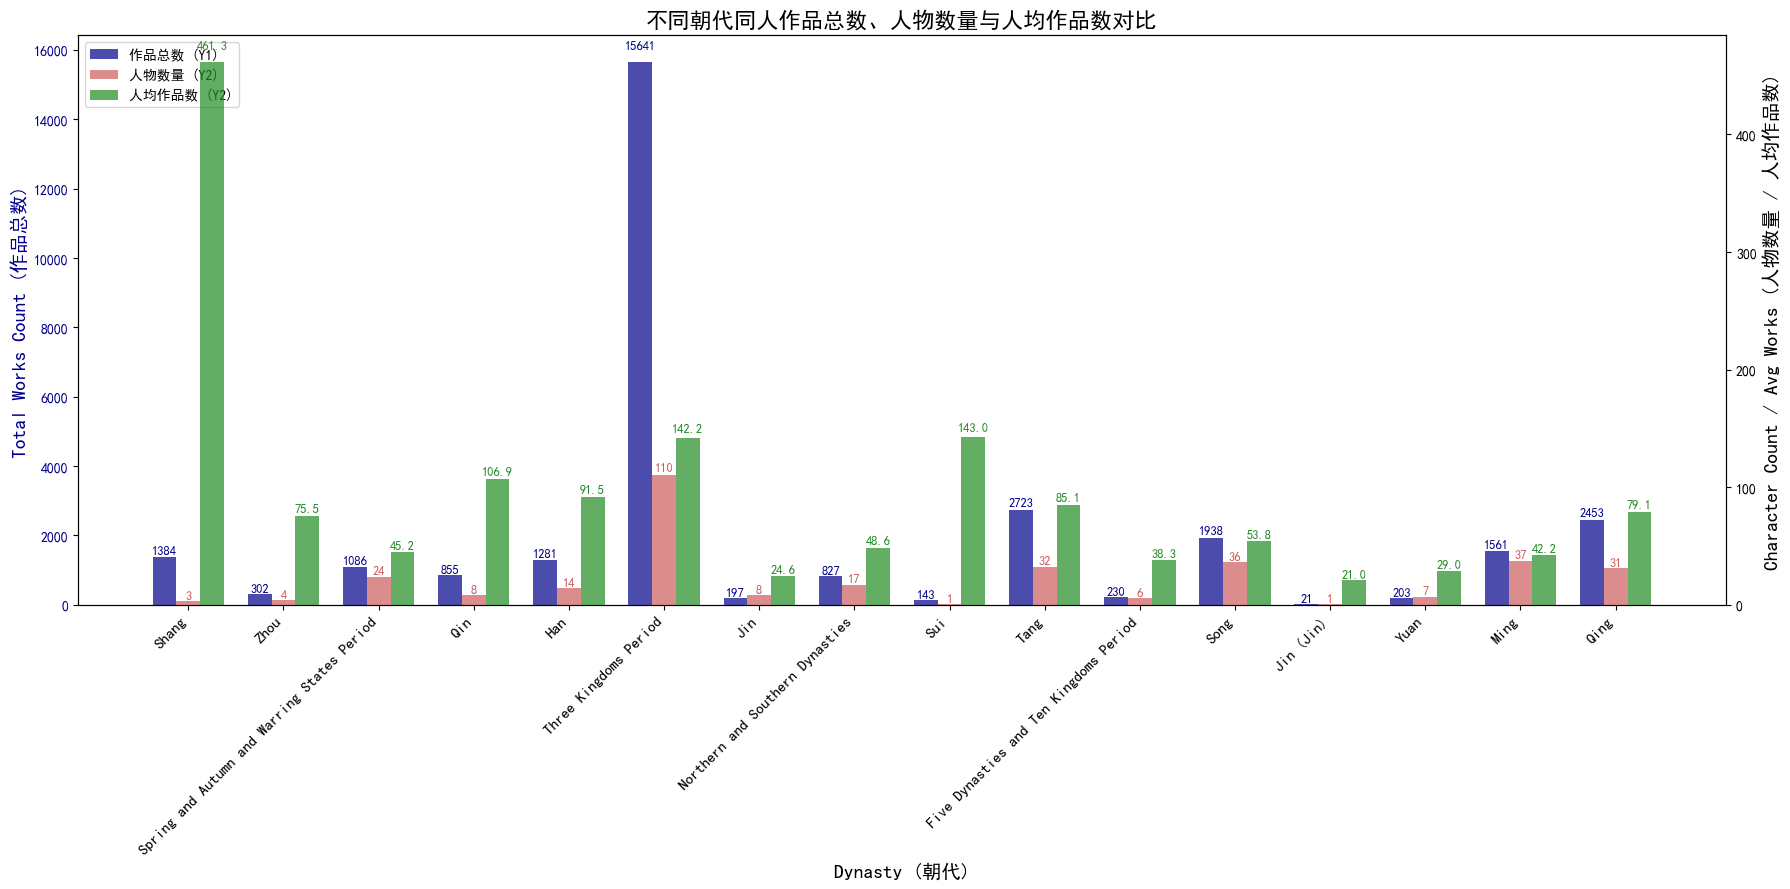

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams['font.sans-serif'] = ['SimHei']  
mpl.rcParams['axes.unicode_minus'] = False    

FILE_PATH = r"\AO3_popular_CHRPS_history.xlsx"


DYNASTY_MAPPING = pd.DataFrame({
    'Dynasty Chinese': [
        '夏', '商', '周', '春秋战国', '秦', '汉', '三国', '两晋', '南北朝', 
        '隋', '唐', '五代', '宋', '辽', '金', '西夏', '元', '明', '清'
    ],
    'Dynasty English': [
        'Xia', 'Shang', 'Zhou', 'Spring and Autumn and Warring States Period', 
        'Qin', 'Han', 'Three Kingdoms Period', 'Jin', 
        'Northern and Southern Dynasties', 'Sui', 'Tang', 
        'Five Dynasties and Ten Kingdoms Period', 'Song', 'Liao', 
        'Jin (Jin)', 'Western Xia', 'Yuan', 'Ming', 'Qing'
    ]
})


DYNASTY_MAPPING['Order'] = DYNASTY_MAPPING.index + 1

def infer_dynasty(df, mapping_data):
    """
    根据数据中的 'Dynasty Chinese' 列，映射到标准的 'Dynasty English' 和排序键。
    """
    
    if 'Dynasty Chinese' not in df.columns:
        print("警告：数据中未找到 'Dynasty Chinese' 列。将尝试从 Character Name 推断...")
        def simple_guess(name):
            if '汉' in name or 'Han' in name: return '汉'
            if '唐' in name or 'Tang' in name: return '唐'
            if '清' in name or 'Qing' in name: return '清'
            if '三國' in name or 'Three Kingdoms' in name: return '三国'
            return np.nan

        df['Dynasty Chinese'] = df['Character Name'].astype(str).apply(simple_guess)

    if 'Dynasty English' in df.columns:
        print("发现原始数据中存在 'Dynasty English' 列，正在删除以避免合并冲突。")
        df = df.drop(columns=['Dynasty English'])
    
    df_merged = pd.merge(
        df,
        mapping_data,
        on='Dynasty Chinese',
        how='left'
    )
    
    df_merged.dropna(subset=['Dynasty English'], inplace=True)
    
    return df_merged


def analyze_and_plot_dynasty_data(file_path, mapping_data):
    """执行数据加载、统计、排序和双Y轴多组柱状图绘图"""
    try:
        # 1. 数据加载
        df = pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"错误：文件未找到，请检查路径：{file_path}")
        return
    except KeyError:
        print("错误：请确保您的Excel文件至少包含 'Character Name' 和 'Works Count' 列。")
        return
        
    df_processed = infer_dynasty(df, mapping_data)

    df_character_count = df_processed.groupby('Dynasty English')['Character Name'].nunique().reset_index(name='Character Count')
    
    df_works_sum = df_processed.groupby('Dynasty English')['Works Count'].sum().reset_index(name='Total Works Count')
    
    df_stats = pd.merge(df_character_count, df_works_sum, on='Dynasty English')

    df_stats['Avg Works Per Character'] = df_stats['Total Works Count'] / df_stats['Character Count']

    df_stats = pd.merge(
        df_stats,
        mapping_data[['Dynasty English', 'Order']],
        on='Dynasty English',
        how='left'
    ).sort_values(by='Order')
    
    print("## 朝代统计结果 (包含作品总数、人物数量和人均作品数):")
    print(df_stats[['Dynasty English', 'Character Count', 'Total Works Count', 'Avg Works Per Character']].to_markdown(index=False))
    print("-" * 50)
    
    x = np.arange(len(df_stats['Dynasty English']))
    width = 0.25  # 柱子宽度
    
    fig, ax1 = plt.subplots(figsize=(18, 9))
    
    color1 = 'darkblue'
    ax1.set_xlabel('Dynasty (朝代)', fontsize=14)
    ax1.set_ylabel('Total Works Count (作品总数)', color=color1, fontsize=14)
    
    rects1 = ax1.bar(
        x - width, 
        df_stats['Total Works Count'], 
        width, 
        color=color1,
        alpha=0.7,
        label='作品总数 (Y1)'
    )
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_ylim(bottom=0) 
    
    ax2 = ax1.twinx()  
    color2 = 'indianred'
    color3 = 'forestgreen'
    ax2.set_ylabel('Character Count / Avg Works (人物数量 / 人均作品数)', fontsize=14)
    
    rects2 = ax2.bar(
        x, 
        df_stats['Character Count'], 
        width, 
        color=color2,
        alpha=0.7,
        label='人物数量 (Y2)'
    )
    
    rects3 = ax2.bar(
        x + width, 
        df_stats['Avg Works Per Character'], 
        width, 
        color=color3,
        alpha=0.7,
        label='人均作品数 (Y2)'
    )
    ax2.tick_params(axis='y')
    ax2.set_ylim(bottom=0)
    
    def autolabel(ax, rects, is_decimal=False, color='black'):
        """在柱子上方添加数值标签"""
        for rect in rects:
            height = rect.get_height()
            if height > 0:
                text_val = f'{height:.1f}' if is_decimal else f'{int(height)}'
                ax.text(
                    rect.get_x() + rect.get_width() / 2, 
                    height * 1.02,
                    text_val,
                    ha='center', va='bottom', fontsize=9, color=color
                )

    # 标签 Total Works Count (Y1)
    autolabel(ax1, rects1, is_decimal=False, color=color1)
    # 标签 Character Count (Y2)
    autolabel(ax2, rects2, is_decimal=False, color=color2)
    # 标签 Avg Works Per Character (Y2)
    autolabel(ax2, rects3, is_decimal=True, color=color3)

    ax1.set_title('不同朝代同人作品总数、人物数量与人均作品数对比', fontsize=16)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_stats['Dynasty English'], rotation=45, ha='right', fontsize=11)
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=10)
    
    fig.tight_layout()
    plt.show()


if __name__ == "__main__":
    analyze_and_plot_dynasty_data(FILE_PATH, DYNASTY_MAPPING)

Existing 'Dynasty English' column found and removed to prevent merge conflict.
## Dynasty Statistics (Character Count and Avg Works Per Character):
| Dynasty English                             |   Character Count |   Avg Works Per Character |
|:--------------------------------------------|------------------:|--------------------------:|
| Shang                                       |                 3 |                  461.333  |
| Zhou                                        |                 4 |                   75.5    |
| Spring and Autumn and Warring States Period |                24 |                   45.25   |
| Qin                                         |                 8 |                  106.875  |
| Han                                         |                14 |                   91.5    |
| Three Kingdoms Period                       |               110 |                  142.191  |
| Jin                                         |                 8 |                 

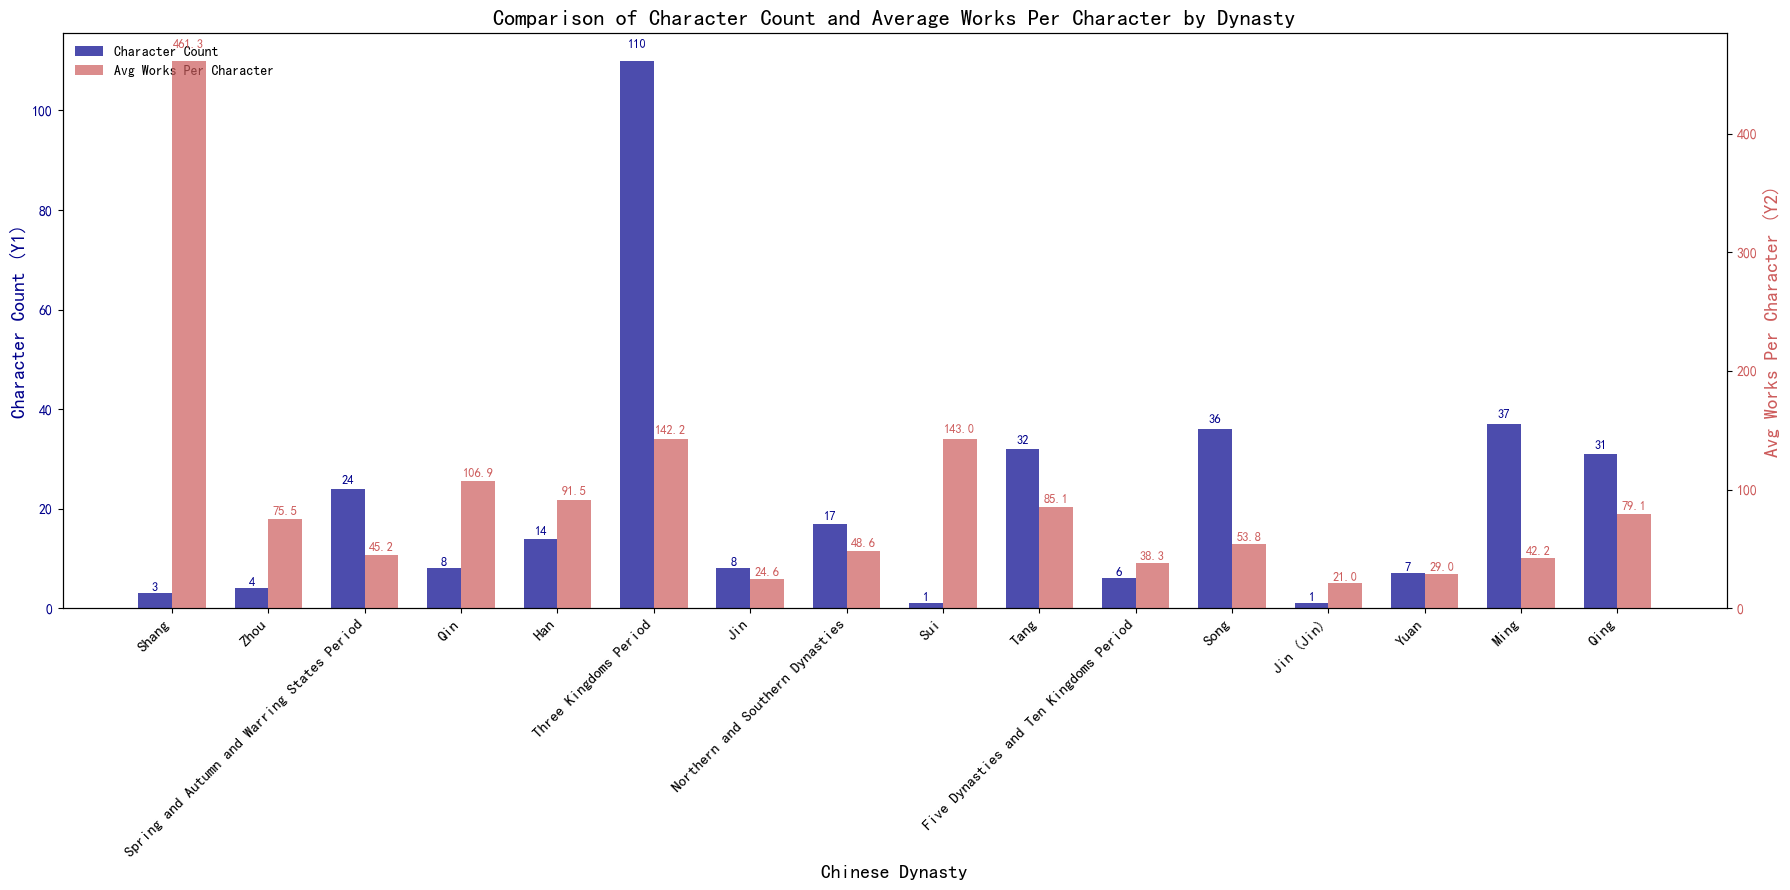

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# 解决中文显示问题：虽然图表最终使用英文，但保留字体设置以避免控制台输出或其他中文乱码问题
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False    # 解决保存图像时负号 '-' 显示为方块的问题

# 文件路径
FILE_PATH = r"C:\Users\yangx\Desktop\格罗宁根岗位\2025\HKDH CHRPS\AO3_popular_CHRPS_history.xlsx"

# =========================================
# 1. Dynasty Mapping and Order
# =========================================
DYNASTY_MAPPING = pd.DataFrame({
    'Dynasty Chinese': [
        '夏', '商', '周', '春秋战国', '秦', '汉', '三国', '两晋', '南北朝', 
        '隋', '唐', '五代', '宋', '辽', '金', '西夏', '元', '明', '清'
    ],
    'Dynasty English': [
        'Xia', 'Shang', 'Zhou', 'Spring and Autumn and Warring States Period', 
        'Qin', 'Han', 'Three Kingdoms Period', 'Jin', 
        'Northern and Southern Dynasties', 'Sui', 'Tang', 
        'Five Dynasties and Ten Kingdoms Period', 'Song', 'Liao', 
        'Jin (Jin)', 'Western Xia', 'Yuan', 'Ming', 'Qing'
    ]
})

# Add Order Key
DYNASTY_MAPPING['Order'] = DYNASTY_MAPPING.index + 1

# =========================================
# 2. Dynasty Inference Function
# =========================================
def infer_dynasty(df, mapping_data):
    """
    Maps the 'Dynasty Chinese' column to the standardized 'Dynasty English' and Order key.
    """
    
    # 1. Handle missing 'Dynasty Chinese' column (placeholder logic)
    if 'Dynasty Chinese' not in df.columns:
        print("Warning: 'Dynasty Chinese' column not found. Attempting simple inference from 'Character Name'...")
        def simple_guess(name):
            if '汉' in name or 'Han' in name: return '汉'
            if '唐' in name or 'Tang' in name: return '唐'
            if '清' in name or 'Qing' in name: return '清'
            if '三國' in name or 'Three Kingdoms' in name: return '三国'
            return np.nan

        df['Dynasty Chinese'] = df['Character Name'].astype(str).apply(simple_guess)

    # 2. Avoid Column Naming Conflict: Drop existing 'Dynasty English' column if present.
    if 'Dynasty English' in df.columns:
        print("Existing 'Dynasty English' column found and removed to prevent merge conflict.")
        df = df.drop(columns=['Dynasty English'])
    
    # 3. Perform Merge: Introduce the standardized 'Dynasty English' and 'Order'
    df_merged = pd.merge(
        df,
        mapping_data,
        on='Dynasty Chinese',
        how='left'
    )
    
    # 4. Remove records where the dynasty could not be mapped
    df_merged.dropna(subset=['Dynasty English'], inplace=True)
    
    return df_merged

# =========================================
# 3. Analysis and Plotting Function (English Labels)
# =========================================
def analyze_and_plot_dynasty_data(file_path, mapping_data):
    """Performs data analysis and plots the dual Y-axis bar chart with English labels."""
    try:
        # 1. Data Loading
        df = pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: File not found. Please check the path: {file_path}")
        return
    except KeyError:
        print("Error: Please ensure your Excel file contains 'Character Name' and 'Works Count' columns.")
        return
        
    # 2. Preprocessing and Dynasty Mapping
    df_processed = infer_dynasty(df, mapping_data)

    # 3. Calculation
    
    # Calculate unique characters per dynasty
    df_character_count = df_processed.groupby('Dynasty English')['Character Name'].nunique().reset_index(name='Character Count')
    
    # Calculate total works per dynasty
    df_works_sum = df_processed.groupby('Dynasty English')['Works Count'].sum().reset_index(name='Total Works Count')
    
    # Merge counts
    df_stats = pd.merge(df_character_count, df_works_sum, on='Dynasty English')

    # Calculate Avg Works Per Character
    df_stats['Avg Works Per Character'] = df_stats['Total Works Count'] / df_stats['Character Count']

    # 4. Apply Historical Order and Sort
    df_stats = pd.merge(
        df_stats,
        mapping_data[['Dynasty English', 'Order']],
        on='Dynasty English',
        how='left'
    ).sort_values(by='Order')
    
    print("## Dynasty Statistics (Character Count and Avg Works Per Character):")
    print(df_stats[['Dynasty English', 'Character Count', 'Avg Works Per Character']].to_markdown(index=False))
    print("-" * 50)
    
    # 5. Plotting: Dual Y-Axis Grouped Bar Chart
    
    # X-axis setup
    x = np.arange(len(df_stats['Dynasty English']))
    width = 0.35  # Bar width
    
    fig, ax1 = plt.subplots(figsize=(18, 9))
    
    # --- Y1 Axis: Character Count ---
    color1 = 'darkblue'
    ax1.set_xlabel('Chinese Dynasty', fontsize=14)
    ax1.set_ylabel('Character Count (Y1)', color=color1, fontsize=14)
    
    # Plot Character Count Bars (Y1)
    rects1 = ax1.bar(
        x - width/2, 
        df_stats['Character Count'], 
        width, 
        color=color1,
        alpha=0.7,
        label='Character Count' # English Label for Legend
    )
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_ylim(bottom=0) 
    
    # --- Y2 Axis: Avg Works Per Character ---
    ax2 = ax1.twinx()  # Create second Y-axis, sharing X-axis
    color2 = 'indianred'
    ax2.set_ylabel('Avg Works Per Character (Y2)', color=color2, fontsize=14)
    
    # Plot Avg Works Per Character Bars (Y2)
    rects2 = ax2.bar(
        x + width/2, 
        df_stats['Avg Works Per Character'], 
        width, 
        color=color2,
        alpha=0.7,
        label='Avg Works Per Character' # English Label for Legend
    )
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_ylim(bottom=0) 
    
    # --- Add Value Labels ---
    def autolabel(ax, rects, is_decimal=False, color='black'):
        """Adds value labels on top of the bars."""
        for rect in rects:
            height = rect.get_height()
            if height > 0:
                text_val = f'{height:.1f}' if is_decimal else f'{int(height)}'
                ax.text(
                    rect.get_x() + rect.get_width() / 2, 
                    height * 1.02, 
                    text_val,
                    ha='center', va='bottom', fontsize=9, color=color
                )

    # Label Character Count (Y1)
    autolabel(ax1, rects1, is_decimal=False, color=color1)
    # Label Avg Works Per Character (Y2)
    autolabel(ax2, rects2, is_decimal=True, color=color2)

    # --- Final Settings ---
    # Title (English)
    ax1.set_title('Comparison of Character Count and Average Works Per Character by Dynasty', fontsize=16)
    
    # Set X-axis ticks and labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_stats['Dynasty English'], rotation=45, ha='right', fontsize=11)
    
    # Combine Legends (English)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=10, frameon=False)
    
    fig.tight_layout()
    plt.show()

# =========================================
# Execution
# =========================================
if __name__ == "__main__":
    analyze_and_plot_dynasty_data(FILE_PATH, DYNASTY_MAPPING)

In [4]:
import pandas as pd
import re

def load_data():
    print("正在加载数据文件...")
    
    try:
        df = pd.read_csv(r"last_fandom.csv", encoding='utf-8-sig')
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(r"last_fandom.csv", encoding='gbk')
        except UnicodeDecodeError:
            df = pd.read_csv(r"last_fandom.csv", encoding='latin-1')
    
    print(f"数据记录数: {len(df)}")
    

    if 'fandom_tag' not in df.columns:
        print("数据中没有fandom_tag列")
        return None
    
    return df

def clean_fandom_data(fandom_str):

    if pd.isna(fandom_str) or fandom_str == '':
        return []
    
    # 替换不规范的逗号分隔符
    fandom_str = str(fandom_str).replace('，', ',')  # 中文逗号转英文逗号
    
    # 分割fandom标签
    fandoms = [fandom.strip() for fandom in fandom_str.split(',') if fandom.strip()]
    
    # 过滤空值和无效字符
    cleaned_fandoms = []
    for fandom in fandoms:
        if fandom and fandom not in ['，', ',', ' ', '']:
            cleaned_fandoms.append(fandom)
    
    return cleaned_fandoms

def extract_all_fandoms(df):
    print("正在提取和统计fandom...")
    
    all_fandoms = []
    
    for idx, row in df.iterrows():
        fandom_str = row['fandom_tag']
        fandoms = clean_fandom_data(fandom_str)
        all_fandoms.extend(fandoms)
        
        # 显示前几行的处理过程
        if idx < 5:
            print(f"第{idx+1}行: '{fandom_str}' -> {fandoms}")
    
    # 统计频率
    fandom_counts = {}
    for fandom in all_fandoms:
        fandom_counts[fandom] = fandom_counts.get(fandom, 0) + 1
    
    # 转换为DataFrame并按频率排序
    fandom_df = pd.DataFrame({
        'fandom_name': list(fandom_counts.keys()),
        'frequency': list(fandom_counts.values())
    }).sort_values('frequency', ascending=False).reset_index(drop=True)
    
    print(f"\n提取到 {len(fandom_df)} 个不同的fandom")
    print(f"总fandom出现次数: {len(all_fandoms)}")
    
    return fandom_df

def analyze_fandom_categories(fandom_df):
    print("\n正在分析fandom类别...")
    
    categories = {
        'Historical RPF': ['Chinese History RPF', 'Tang Dynasty RPF', 'Song Dynasty RPF', 'Ming Dynasty RPF', 'Qing Dynasty RPF'],
        'Three Kingdoms': ['Romance of the Three Kingdoms', '三国演义', '三國演義'],
        'Video Games': ['Dynasty Warriors', 'Warriors Orochi', 'Ashes of the Kingdom', '代号鸢', 'Total War'],
        'TV Series': ['The Advisors Alliance', '军师联盟', 'Red Cliff', '赤壁', 'The Longest Day in Chang\'an', '长安十二时辰'],
        'Manhua/Comics': ['The Ravages of Time', '火鳳燎原', 'The Chat of the Three Kingdoms'],
        'Other Media': ['Secret of the Three Kingdoms', '三国机密之潜龙在渊']
    }
    
    fandom_categories = []
    
    for fandom in fandom_df['fandom_name']:
        category_found = False
        for category, keywords in categories.items():
            for keyword in keywords:
                if keyword in fandom:
                    fandom_categories.append(category)
                    category_found = True
                    break
            if category_found:
                break
        
        if not category_found:
            fandom_categories.append('Other')
    
    fandom_df['category'] = fandom_categories
    
    # 统计各类别数量
    category_counts = fandom_df['category'].value_counts()
    print("fandom类别分布:")
    for category, count in category_counts.items():
        percentage = count / len(fandom_df) * 100
        print(f"  {category}: {count} ({percentage:.1f}%)")
    
    return fandom_df

def save_results(fandom_df):
    output_path = r"AO3_fandom.csv"
    
    try:
        fandom_df.to_csv(output_path, index=False, encoding='utf-8-sig')
        print(f"fandom统计已保存: {output_path}")
    except Exception as e:
        try:
            fandom_df.to_csv(output_path, index=False, encoding='gbk')
            print(f"fandom统计已使用GBK编码保存: {output_path}")
        except Exception as e2:
            print(f"保存fandom统计失败: {e2}")
    
    return output_path

def generate_detailed_statistics(fandom_df, df):
    print("\n" + "="*60)
    print("📊 fandom详细统计信息")
    print("="*60)
    
    # 基本统计
    total_characters = len(df)
    characters_with_fandom = len(df[df['fandom_tag'].notna() & (df['fandom_tag'] != '')])
    
    print(f"总角色数量: {total_characters}")
    print(f"有fandom信息的角色数量: {characters_with_fandom}")
    print(f"fandom信息覆盖率: {characters_with_fandom/total_characters*100:.1f}%")
    print(f"不同fandom数量: {len(fandom_df)}")
    
    print(f"\n最流行的fandom (前20):")
    top_fandoms = fandom_df.head(20)
    for idx, row in top_fandoms.iterrows():
        print(f"  {idx+1:2d}. {row['fandom_name']}: {row['frequency']}次")
    
    print(f"\n按类别统计:")
    category_stats = fandom_df.groupby('category').agg({
        'fandom_name': 'count',
        'frequency': 'sum'
    }).rename(columns={'fandom_name': 'fandom_count', 'frequency': 'total_occurrences'})
    
    for category, row in category_stats.iterrows():
        print(f"  {category}: {row['fandom_count']}个fandom, 总出现{row['total_occurrences']}次")

def main():
    df = load_data()
    
    if df is None:
        return
    
    fandom_df = extract_all_fandoms(df)
    
    fandom_df = analyze_fandom_categories(fandom_df)
    
    output_path = save_results(fandom_df)
    
    generate_detailed_statistics(fandom_df, df)
    
    print(f"结果文件: {output_path}")

if __name__ == "__main__":
    main()

🚀 开始分析fandom数据...
正在加载数据文件...
数据记录数: 688
正在提取和统计fandom...
第1行: 'Chinese History RPF，Chì Bì | Red Cliff (2008)，三国演义 - 罗贯中 | Romance of the Three Kingdoms - Luo Guanzhong，代号鸢 | Ashes of the Kingdom (Video Game)，军师联盟 | The Advisors Alliance (TV)，火鳳燎原 | The Ravages of Time (Manhua)' -> ['Chinese History RPF', 'Chì Bì | Red Cliff (2008)', '三国演义 - 罗贯中 | Romance of the Three Kingdoms - Luo Guanzhong', '代号鸢 | Ashes of the Kingdom (Video Game)', '军师联盟 | The Advisors Alliance (TV)', '火鳳燎原 | The Ravages of Time (Manhua)']
第2行: 'Chinese History RPF，Shin Sangokumusou | Dynasty Warriors，Warriors Orochi，三国演义 - 罗贯中 | Romance of the Three Kingdoms - Luo Guanzhong，代号鸢 | Ashes of the Kingdom (Video Game)，火鳳燎原 | The Ravages of Time (Manhua)' -> ['Chinese History RPF', 'Shin Sangokumusou | Dynasty Warriors', 'Warriors Orochi', '三国演义 - 罗贯中 | Romance of the Three Kingdoms - Luo Guanzhong', '代号鸢 | Ashes of the Kingdom (Video Game)', '火鳳燎原 | The Ravages of Time (Manhua)']
第3行: 'Chinese History RPF' -> ['Chines

In [2]:
pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]

Note: you may need to restart the kernel 

Existing 'Dynasty English' column found and removed to prevent merge conflict.
## Dynasty Statistics (Character Count and Work Count):
| Dynasty English                                           |   Character Count |   Mean Work Count |   Max Work Count |   Median Work Count |   Order |
|:----------------------------------------------------------|------------------:|------------------:|-----------------:|--------------------:|--------:|
| Shang (c. 1600–c. 1046 BCE)                               |                 2 |                 3 |                5 |                   3 |       2 |
| Zhou (c. 1046–256 BCE)                                    |                 4 |                11 |               21 |                  10 |       3 |
| Spring and Autumn and Warring States Period (770–221 BCE) |                41 |                13 |               72 |                   4 |       4 |
| Qin (221–206 BCE)                                         |                17 |                31 

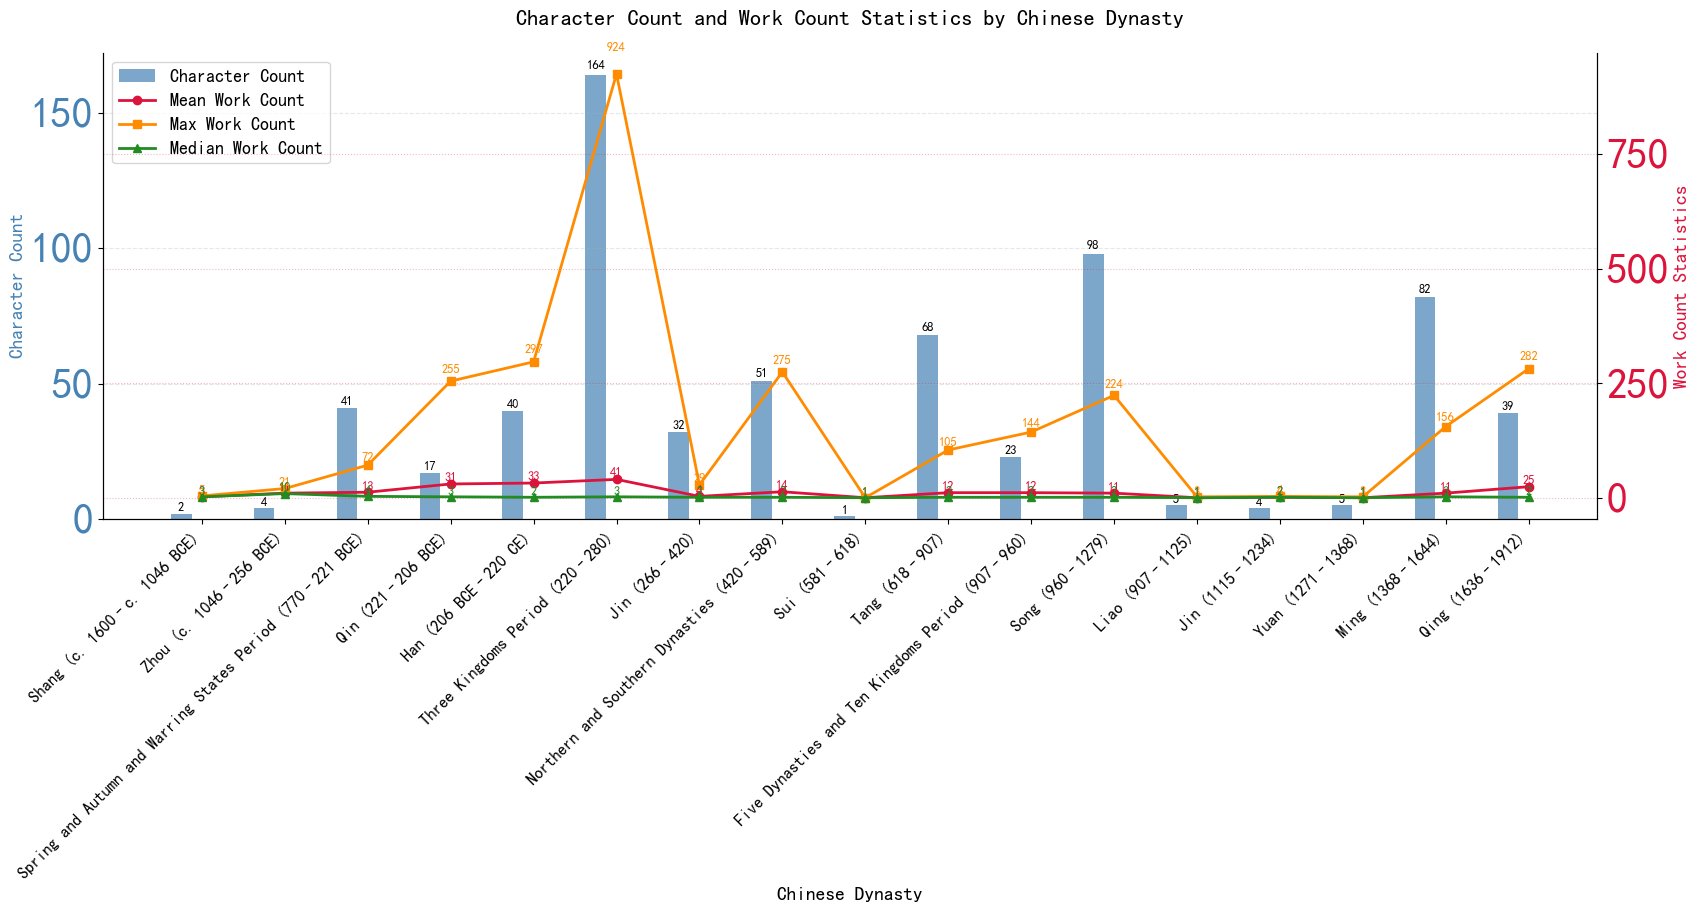

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

FANDOM_FILE_PATH = r"last_fandom.csv"
RELATIONSHIP_FILE_PATH = r"Relationship_original_tag_characterAtoE.xlsx"

DYNASTY_MAPPING = pd.DataFrame({
    'Dynasty Chinese': [
        '夏', '商', '周', '春秋战国', '秦', '汉', '三国', '两晋', '南北朝', 
        '隋', '唐', '五代', '宋', '辽', '金', '西夏', '元', '明', '清'
    ],
    'Dynasty English': [
        'Xia (c. 2070–c. 1600 BCE)', 
        'Shang (c. 1600–c. 1046 BCE)', 
        'Zhou (c. 1046–256 BCE)', 
        'Spring and Autumn and Warring States Period (770–221 BCE)', 
        'Qin (221–206 BCE)', 
        'Han (206 BCE–220 CE)', 
        'Three Kingdoms Period (220–280)', 
        'Jin (266–420)', 
        'Northern and Southern Dynasties (420–589)', 
        'Sui (581–618)', 
        'Tang (618–907)', 
        'Five Dynasties and Ten Kingdoms Period (907–960)', 
        'Song (960–1279)', 
        'Liao (907–1125)', 
        'Jin (1115–1234)', 
        'Western Xia (1038–1227)', 
        'Yuan (1271–1368)', 
        'Ming (1368–1644)', 
        'Qing (1636–1912)'
    ]
})


DYNASTY_MAPPING['Order'] = DYNASTY_MAPPING.index + 1

def process_relationship_data(relationship_file_path, fandom_file_path):
    """处理关系数据，统计每个角色对应的作品数量"""
    
    relationship_df = pd.read_excel(relationship_file_path)
    
    fandom_df = pd.read_csv(fandom_file_path, encoding='gbk')
    
    character_work_count = {}
    
    for _, row in relationship_df.iterrows():
        work_count = row['work_count']
        
        for col in ['character_A', 'character_B', 'character_C', 'character_D', 'character_E']:
            character = row[col]
            if pd.notna(character) and character != '':
                if character in character_work_count:
                    character_work_count[character] += work_count
                else:
                    character_work_count[character] = work_count
    
    work_count_df = pd.DataFrame(list(character_work_count.items()), 
                                columns=['character_name', 'total_work_count'])
    
    return work_count_df, fandom_df


def infer_dynasty(df, mapping_data):
    """将朝代中文映射到标准化的英文朝代和顺序"""
    
    if 'Dynasty Chinese' not in df.columns:
        print("Warning: 'Dynasty Chinese' column not found. Attempting simple inference from 'character_name'...")
        def simple_guess(name):
            if '汉' in name or 'Han' in name: return '汉'
            if '唐' in name or 'Tang' in name: return '唐'
            if '清' in name or 'Qing' in name: return '清'
            if '三國' in name or 'Three Kingdoms' in name: return '三国'
            if '宋' in name or 'Song' in name: return '宋'
            if '明' in name or 'Ming' in name: return '明'
            if '周' in name or 'Zhou' in name: return '周'
            if '秦' in name or 'Qin' in name: return '秦'
            if '元' in name or 'Yuan' in name: return '元'
            return np.nan

        df['Dynasty Chinese'] = df['character_name'].astype(str).apply(simple_guess)


    if 'Dynasty English' in df.columns:
        print("Existing 'Dynasty English' column found and removed to prevent merge conflict.")
        df = df.drop(columns=['Dynasty English'])
    

    df_merged = pd.merge(
        df,
        mapping_data,
        on='Dynasty Chinese',
        how='left'
    )
    

    df_merged.dropna(subset=['Dynasty English'], inplace=True)
    
    return df_merged

def analyze_and_plot_dynasty_data(fandom_file_path, relationship_file_path, mapping_data):
    """执行数据分析并绘制双x轴图表"""
    

    work_count_df, fandom_df = process_relationship_data(relationship_file_path, fandom_file_path)
    

    merged_df = pd.merge(fandom_df, work_count_df, on='character_name', how='left')
    

    df_processed = infer_dynasty(merged_df, mapping_data)
    

    dynasty_stats = df_processed.groupby('Dynasty English').agg({
        'character_name': 'count',  
        'total_work_count': ['mean', 'max', 'median']  
    }).round(2)
    dynasty_stats = dynasty_stats.astype(int)

    dynasty_stats.columns = ['Character Count', 'Mean Work Count', 'Max Work Count', 'Median Work Count']
    dynasty_stats = dynasty_stats.reset_index()
    
    df_final = pd.merge(
        dynasty_stats,
        mapping_data[['Dynasty English', 'Order']],
        on='Dynasty English',
        how='left'
    ).sort_values(by='Order')
    
    print("## Dynasty Statistics (Character Count and Work Count):")
    print(df_final.to_markdown(index=False))
    print("-" * 50)
    
    fig, ax1 = plt.subplots(figsize=(18, 10))
    

    x = np.arange(len(df_final['Dynasty English']))
    width = 0.25  
    
    bars1 = ax1.bar(x - width, df_final['Character Count'], width, 
                   color='steelblue', alpha=0.7, label='Character Count')
    
    ax1.set_xlabel('Chinese Dynasty', fontsize=14)
    ax1.set_ylabel('Character Count', fontsize=14, color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    
    ax2 = ax1.twinx()
    

    line1 = ax2.plot(x, df_final['Mean Work Count'], 'o-', color='crimson', 
                    linewidth=2, markersize=6, label='Mean Work Count')
    line2 = ax2.plot(x, df_final['Max Work Count'], 's-', color='darkorange', 
                    linewidth=2, markersize=6, label='Max Work Count')
    line3 = ax2.plot(x, df_final['Median Work Count'], '^-', color='forestgreen', 
                    linewidth=2, markersize=6, label='Median Work Count')
    
    ax2.set_ylabel('Work Count Statistics', fontsize=14, color='crimson')
    ax2.tick_params(axis='y', labelcolor='crimson')
    

    plt.title('Character Count and Work Count Statistics by Chinese Dynasty', fontsize=16, pad=20)
    

    ax1.set_xticks(x)
    ax1.set_xticklabels(df_final['Dynasty English'], rotation=45, ha='right', fontsize=12)
    

    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.grid(axis='y', alpha=0.3, linestyle=':', color='crimson')
    

    def autolabel_bars(rects):
        for rect in rects:
            height = rect.get_height()
            if height > 0:
                ax1.text(rect.get_x() + rect.get_width()/2, height * 1.01,
                        f'{int(height)}', ha='center', va='bottom', 
                        fontsize=9, fontweight='bold')
    

    def autolabel_lines(x_data, y_data, color):
        for i, (x, y) in enumerate(zip(x_data, y_data)):
            if y > 0:
                ax2.text(x, y * 1.05, f'{y}', ha='center', va='bottom',
                        fontsize=9, fontweight='bold', color=color)
    
    autolabel_bars(bars1)
    autolabel_lines(x, df_final['Mean Work Count'], 'crimson')
    autolabel_lines(x, df_final['Max Work Count'], 'darkorange')
    autolabel_lines(x, df_final['Median Work Count'], 'forestgreen')
    

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=13)
    

    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    fig.tight_layout()
    

    total_characters = df_final['Character Count'].sum()
    total_works = df_final['Character Count'] * df_final['Mean Work Count']
    total_works_sum = total_works.sum()
    
    print(f"\n📊 统计摘要:")
    print(f"总角色数量: {total_characters}")
    print(f"总作品数量估算: {total_works_sum:.0f}")
    print(f"涵盖朝代数量: {len(df_final)}")
    print(f"平均每个朝代的角色数量: {total_characters/len(df_final):.1f}")
    print(f"平均每个角色的作品数量: {df_final['Mean Work Count'].mean():.2f}")
    

    top_dynasty_chars = df_final.loc[df_final['Character Count'].idxmax()]
    print(f"角色最多的朝代: {top_dynasty_chars['Dynasty English']} ({top_dynasty_chars['Character Count']}个角色)")
    

    top_dynasty_works = df_final.loc[df_final['Mean Work Count'].idxmax()]
    print(f"平均作品最多的朝代: {top_dynasty_works['Dynasty English']} (平均{top_dynasty_works['Mean Work Count']}个作品)")
    
    plt.show()
    
    return df_final

if __name__ == "__main__":
    result_df = analyze_and_plot_dynasty_data(FANDOM_FILE_PATH, RELATIONSHIP_FILE_PATH, DYNASTY_MAPPING)

In [1]:
import pandas as pd

def count_special_characters_relationship():
    """统计包含特殊character的relationship数量"""
    

    file_path = r"Relationship1104_Chinese_corrected.xlsx"
    
    try:
        df = pd.read_excel(file_path)
        print(f"成功读取文件，总记录数: {len(df)}")
    except Exception as e:
        print(f"读取文件失败: {e}")
        return
    

    special_characters = [
        'Everyone',
        'Original Character(s)',
        'You',
        'Me | Fanwork Creator(s)',
        'Original Female Character(s)',
        'Original Male Character(s)',
        'Other(s)'
    ]
    

    df_valid = df[df['work_count'] > 0].copy()
    print(f"work_count不为0的记录数: {len(df_valid)}")
    

    character_columns = ['character_A', 'character_B', 'character_C', 'character_D', 'character_E']
    

    special_character_rows = []
    
    for idx, row in df_valid.iterrows():
        contains_special = False
        special_chars_found = []
        
        for col in character_columns:
            character = row[col]
            if pd.notna(character) and character != '':
                for special_char in special_characters:
                    if special_char in str(character):
                        contains_special = True
                        special_chars_found.append(special_char)
        
        if contains_special:
            special_character_rows.append({
                'row_index': idx,
                'special_characters': ', '.join(set(special_chars_found))  # 去重
            })
    

    result_df = pd.DataFrame(special_character_rows)
    

    total_special_rows = len(special_character_rows)
    total_valid_rows = len(df_valid)
    
    print(f"\n📊 统计结果:")
    print(f"work_count不为0的总记录数: {total_valid_rows}")
    print(f"包含特殊character的记录数: {total_special_rows}")
    print(f"占比: {total_special_rows/total_valid_rows*100:.2f}%")
    

    special_char_counts = {}
    for special_char in special_characters:
        count = 0
        for idx, row in df_valid.iterrows():
            for col in character_columns:
                character = row[col]
                if pd.notna(character) and character != '' and special_char in str(character):
                    count += 1
                    break  
        special_char_counts[special_char] = count
    
    print(f"\n各特殊character出现次数:")
    for char, count in special_char_counts.items():
        print(f"  {char}: {count}次")
    

    if total_special_rows > 0:
        print(f"\n包含特殊character的示例行 (前10行):")
        sample_indices = result_df['row_index'].head(10).tolist()
        
        for idx in sample_indices:
            row_data = df_valid.loc[idx]
            special_chars = result_df[result_df['row_index'] == idx]['special_characters'].iloc[0]
            
            print(f"\n行 {idx}:")
            print(f"  特殊character: {special_chars}")
            print(f"  work_count: {row_data['work_count']}")
            print(f"  relationship_type: {row_data['relationship_type']}")
            for col in character_columns:
                if pd.notna(row_data[col]) and row_data[col] != '':
                    print(f"  {col}: {row_data[col]}")
    

    if total_special_rows > 0:

        detailed_result = df_valid.loc[result_df['row_index']].copy()
        detailed_result['special_characters'] = result_df['special_characters'].values
        
        output_path = r"special_character_relationships.xlsx"
        detailed_result.to_excel(output_path, index=False)
        print(f"\n详细结果已保存到: {output_path}")
    
    return total_valid_rows, total_special_rows, special_char_counts

def main():
    """主函数"""
    print("🚀 开始统计包含特殊character的relationship...")
    
    total_valid, total_special, char_counts = count_special_characters_relationship()
    
    print(f"\n🎉 统计完成！")
    print(f"在 {total_valid} 个有效的relationship中，有 {total_special} 个包含特殊character")

if __name__ == "__main__":
    main()

🚀 开始统计包含特殊character的relationship...
成功读取文件，总记录数: 2941
work_count不为0的记录数: 1135

📊 统计结果:
work_count不为0的总记录数: 1135
包含特殊character的记录数: 143
占比: 12.60%

各特殊character出现次数:
  Everyone: 43次
  Original Character(s): 24次
  You: 45次
  Me | Fanwork Creator(s): 6次
  Original Female Character(s): 11次
  Original Male Character(s): 6次
  Other(s): 10次

包含特殊character的示例行 (前10行):

行 6:
  特殊character: Everyone
  work_count: 1
  relationship_type: 1
  character_A: Crown Prince of Yan | Ji Dan
  character_B: Everyone

行 21:
  特殊character: Original Character(s)
  work_count: 1
  relationship_type: 1
  character_A: Zhang Dun | Zhang Zihou
  character_B: Original Character(s)

行 68:
  特殊character: Other(s)
  work_count: 1
  relationship_type: 1
  character_A: Zhao Gao (258-207 BCE)
  character_B: Other(s)

行 89:
  特殊character: You
  work_count: 11
  relationship_type: 1
  character_A: Lu Kang | Lu Youjie
  character_B: Yang Hu | Yang Shuzi

行 96:
  特殊character: Everyone
  work_count: 1
  relationship_type: 1
  

In [2]:
import pandas as pd

def filter_characters_by_last_fandom():
    """根据last_fandom中的character_name筛选character_1106中的对应行"""
    

    character_1106_path = r"character_1106.csv"
    last_fandom_path = r"last_fandom.csv"
    output_path = r"last_fandom_filtered.csv"
    
    try:

        print("正在读取数据文件...")
        
        try:
            df_character = pd.read_csv(character_1106_path, encoding='utf-8-sig')
        except UnicodeDecodeError:
            try:
                df_character = pd.read_csv(character_1106_path, encoding='gbk')
            except UnicodeDecodeError:
                df_character = pd.read_csv(character_1106_path, encoding='latin-1')
        
        try:
            df_last_fandom = pd.read_csv(last_fandom_path, encoding='utf-8-sig')
        except UnicodeDecodeError:
            try:
                df_last_fandom = pd.read_csv(last_fandom_path, encoding='gbk')
            except UnicodeDecodeError:
                df_last_fandom = pd.read_csv(last_fandom_path, encoding='latin-1')
        
        print(f"character_1106.csv 记录数: {len(df_character)}")
        print(f"last_fandom.csv 记录数: {len(df_last_fandom)}")
        
        print("\ncharacter_1106.csv 列名:", df_character.columns.tolist())
        print("last_fandom.csv 列名:", df_last_fandom.columns.tolist())
        
        character_name_col_1106 = None
        character_name_col_last = None
        
        for col in df_character.columns:
            if 'character' in col.lower() and 'name' in col.lower():
                character_name_col_1106 = col
                break
        if character_name_col_1106 is None:
            character_name_col_1106 = df_character.columns[0]
            print(f"在character_1106中未找到character_name列，使用第一列: {character_name_col_1106}")
        
        for col in df_last_fandom.columns:
            if 'character' in col.lower() and 'name' in col.lower():
                character_name_col_last = col
                break
        if character_name_col_last is None:
            character_name_col_last = df_last_fandom.columns[0]
            print(f"在last_fandom中未找到character_name列，使用第一列: {character_name_col_last}")
        
        print(f"使用列名: character_1106[{character_name_col_1106}], last_fandom[{character_name_col_last}]")
        
        last_fandom_names = set(df_last_fandom[character_name_col_last].dropna().unique())
        print(f"last_fandom中唯一的character_name数量: {len(last_fandom_names)}")
        
        mask = df_character[character_name_col_1106].isin(last_fandom_names)
        df_filtered = df_character[mask].copy()
        
        total_character_1106 = len(df_character)
        total_matched = len(df_filtered)
        match_percentage = (total_matched / len(last_fandom_names)) * 100 if len(last_fandom_names) > 0 else 0
        
        print(f"\n📊 筛选结果统计:")
        print(f"character_1106总记录数: {total_character_1106}")
        print(f"last_fandom中character_name数量: {len(last_fandom_names)}")
        print(f"成功匹配的记录数: {total_matched}")
        print(f"匹配率: {match_percentage:.2f}%")
        
        if total_matched == len(last_fandom_names):
            print("✅ 100%匹配成功！")
        else:
            print("⚠️ 未达到100%匹配")

            unmatched_names = last_fandom_names - set(df_filtered[character_name_col_1106].unique())
            print(f"未匹配的character_name数量: {len(unmatched_names)}")
            if len(unmatched_names) > 0:
                print("未匹配的character_name示例:")
                for name in list(unmatched_names)[:10]:
                    print(f"  - {name}")
        
        print(f"\n正在保存结果到: {output_path}")
        try:
            df_filtered.to_csv(output_path, index=False, encoding='utf-8-sig')
            print("✅ 结果保存成功！")
        except Exception as e:
            try:
                df_filtered.to_csv(output_path, index=False, encoding='gbk')
                print("✅ 结果使用GBK编码保存成功！")
            except Exception as e2:
                print(f"❌ 保存失败: {e2}")
        
        # 显示筛选结果的前几行
        print(f"\n筛选结果前5行:")
        print(df_filtered.head())
        
        return df_filtered, match_percentage
        
    except Exception as e:
        print(f"❌ 处理过程中出现错误: {e}")
        return None, 0

def main():
    """主函数"""
    print("🚀 开始根据last_fandom筛选character_1106数据...")
    
    df_result, match_rate = filter_characters_by_last_fandom()
    
    if df_result is not None:
        print(f"\n🎉 处理完成！匹配率: {match_rate:.2f}%")
    else:
        print("\n❌ 处理失败")

if __name__ == "__main__":
    main()

🚀 开始根据last_fandom筛选character_1106数据...
正在读取数据文件...
character_1106.csv 记录数: 681
last_fandom.csv 记录数: 689

character_1106.csv 列名: ['character_name', 'Gender(Female=1)', 'Dynasty English', 'Max_Official_Rank_Level_EN', 'Power_Type_EN', 'Highest_Degree_EN', 'Cultural_Status_EN', 'Family_Role_to_Monarch_EN']
last_fandom.csv 列名: ['character_name', 'WikiData ID', 'WikiPedia', 'CBDB ID', '性别', 'Chinese Name', 'Dynasty Chinese', 'Dynasty English', 'Wiki Time', 'fandom_tag', 'synonym']
使用列名: character_1106[character_name], last_fandom[character_name]
last_fandom中唯一的character_name数量: 689

📊 筛选结果统计:
character_1106总记录数: 681
last_fandom中character_name数量: 689
成功匹配的记录数: 681
匹配率: 98.84%
⚠️ 未达到100%匹配
未匹配的character_name数量: 8
未匹配的character_name示例:
  - Chu Kingdom 1030-223 BCE (Anthropomorphic)
  - Original Male Character(s)
  - You
  - Original Female Character(s)
  - Me | Fanwork Creator(s)
  - Original Character(s)
  - Other(s)
  - Everyone

正在保存结果到: C:\Users\yangx\Desktop\格罗宁根岗位\2025\HKDH CHRPS\1026拆分r

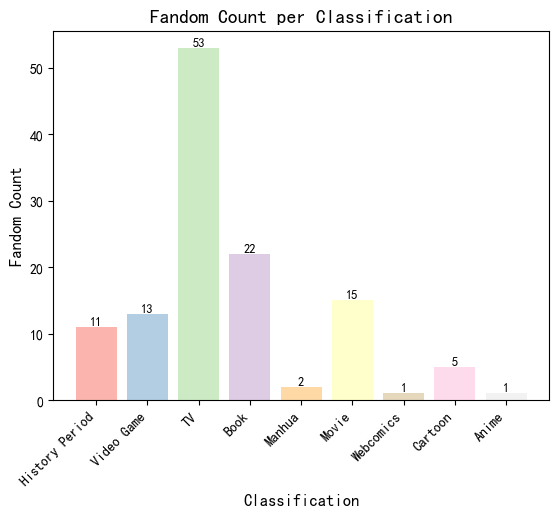

In [8]:
bars2 = plt.bar(classification_summary['classification'], classification_summary['fandom_count'],
                color=plt.cm.Pastel1(np.linspace(0, 1, len(classification_summary))))
plt.title('Fandom Count per Classification', fontsize=14, fontweight='bold')
plt.xlabel('Classification', fontsize=12)
plt.ylabel('Fandom Count', fontsize=12)
plt.xticks(rotation=45, ha='right')


for i, bar in enumerate(bars2):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)